# Final DC Classification Models
## Patrick Ward
### July 1st, 2019

### Read in the data, ensure it it is correct

In [6]:
import pandas as pd
df = pd.read_csv('U:/BMI-733/Data/data.csv',encoding = "ISO-8859-1")
col = ['DC_YEAR', 'scan_field', 'OD']
df = df[col]
df.head()

,DC_YEAR,scan_field,OD
0,2017,CANCER CARDIOPULMONARY ARREST,0
1,2017,MYOCARDIAL INFARCTION,0
2,2017,ALZHEIMERS DEMENTIA,0
3,2017,CHRONIC OBSTRUCTIVE PULMONARY DISEASE,0
4,2017,MULTISYSTEM ORGAN DYSFUNCTION SYNDROME SEIZURE...,0


### Create train/test split

In [9]:
train=df[df['DC_YEAR']==2017]
test=df[df['DC_YEAR']==2018]

X_train=train.scan_field
X_test=test.scan_field
y_train=train.OD
y_test=test.OD

### Create vectorizer to create word, bigram, and trigram features

In [12]:
from sklearn.feature_extraction.text import CountVectorizer 

count_vect = CountVectorizer(ngram_range=(1,3), stop_words='english', min_df=5)
word_vect = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=5)


X_train_bow=count_vect.fit_transform(X_train.values.astype('U'))
X_train_words=word_vect.fit_transform(X_train.values.astype('U'))
X_test_bow=count_vect.transform(X_test.values.astype('U'))

"Name these"
X_train_final=X_train_bow
X_test_final=X_test_bow

### Count the number of features in the model and the number of words

In [19]:
import numpy as np
print(np.shape(X_train_final))
print(np.shape(X_train_bow))
print(np.shape(X_train_words))

(48016, 9849)
(48016, 9849)
(48016, 1820)


### Code to create confusion matrix plots

In [20]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Modeling
### First SVM

In [21]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold

"Set up repeated cross validation"
cross_validation=RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

tuned_parameters = [{'C': [.1, 1, 10, 100]}]

clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=cross_validation, scoring='f1')
clf.fit(X_train_final, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

C:\Users\pjwa227\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.977 (+/-0.018) for {'C': 0.1}
0.973 (+/-0.022) for {'C': 1}
0.968 (+/-0.019) for {'C': 10}
0.966 (+/-0.020) for {'C': 100}


### Next SVM, tuning around best parameter from previous SVM

In [22]:
tuned_parameters = [{'C': [.08, .1, .15, .20]}]

clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=cross_validation, scoring='f1')
clf.fit(X_train_final, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.977 (+/-0.014) for {'C': 0.08}
0.978 (+/-0.013) for {'C': 0.1}
0.977 (+/-0.013) for {'C': 0.15}
0.977 (+/-0.013) for {'C': 0.2}


### Final tuning step

In [23]:
tuned_parameters = [{'C': [.1, .11, .12, .13]}]

clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=cross_validation, scoring='f1')
clf.fit(X_train_final, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_)

0.977 (+/-0.017) for {'C': 0.1}
0.977 (+/-0.017) for {'C': 0.11}
0.977 (+/-0.017) for {'C': 0.12}
0.977 (+/-0.017) for {'C': 0.13}
Best parameters found:
 {'C': 0.11}


### Re-train full data with best parameter value

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     46450
          1       0.99      0.99      0.99      1566

avg / total       1.00      1.00      1.00     48016

Confusion matrix, without normalization
[[46434    16]
 [   22  1544]]


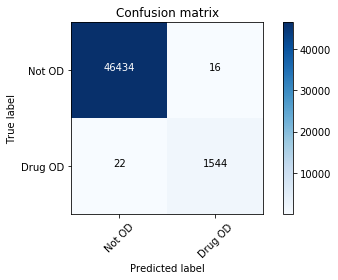

In [24]:
clf=SVC(kernel='linear', C=0.11).fit(X_train_final, y_train)

predicted=clf.predict(X_train_final)
print(classification_report(y_train, predicted))

cnf_matrix=metrics.confusion_matrix(y_train, predicted)
class_names = ['Not OD', 'Drug OD']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

### Deploy on test data

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     35214
          1       0.96      0.98      0.97       912

avg / total       1.00      1.00      1.00     36126

Confusion matrix, without normalization
[[35179    35]
 [   21   891]]


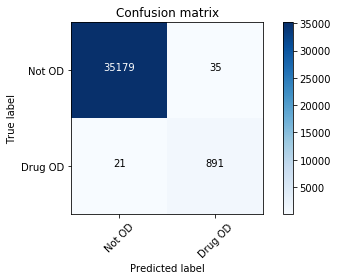

In [25]:
predicted_test=clf.predict(X_test_final)
print(classification_report(y_test, predicted_test))

cnf_matrix=metrics.confusion_matrix(y_test, predicted_test)
class_names = ['Not OD', 'Drug OD']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

### Random forests

In [26]:
tuned_params={
    'n_estimators': [100, 500],
    'max_depth':[None, 5, 10],
}

clf=GridSearchCV(RandomForestClassifier(random_state=1234), tuned_params, cv=cross_validation, scoring='f1')
clf.fit(X_train_final, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_)

0.973 (+/-0.012) for {'max_depth': None, 'n_estimators': 100}
0.973 (+/-0.013) for {'max_depth': None, 'n_estimators': 500}
0.137 (+/-0.096) for {'max_depth': 5, 'n_estimators': 100}
0.179 (+/-0.107) for {'max_depth': 5, 'n_estimators': 500}
0.721 (+/-0.073) for {'max_depth': 10, 'n_estimators': 100}
0.730 (+/-0.075) for {'max_depth': 10, 'n_estimators': 500}
Best parameters found:
 {'max_depth': None, 'n_estimators': 500}


### Next tuning step

In [27]:
tuned_params={
    'n_estimators': [100, 500],
    'max_depth':[None, 100, 500],
}

clf=GridSearchCV(RandomForestClassifier(random_state=1234), tuned_params, cv=cross_validation, scoring='f1')
clf.fit(X_train_final, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_)

0.972 (+/-0.017) for {'max_depth': None, 'n_estimators': 100}
0.972 (+/-0.017) for {'max_depth': None, 'n_estimators': 500}
0.973 (+/-0.017) for {'max_depth': 100, 'n_estimators': 100}
0.974 (+/-0.018) for {'max_depth': 100, 'n_estimators': 500}
0.972 (+/-0.017) for {'max_depth': 500, 'n_estimators': 100}
0.972 (+/-0.017) for {'max_depth': 500, 'n_estimators': 500}
Best parameters found:
 {'max_depth': 100, 'n_estimators': 500}


### Tune the max features

In [28]:
tuned_params={
    'max_features': ['auto', 'sqrt', 'log2'],
}

clf=GridSearchCV(RandomForestClassifier(max_depth=100, n_estimators=500, random_state=1234),
                 tuned_params, cv=cross_validation, scoring='f1')
clf.fit(X_train_final, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_)

0.974 (+/-0.012) for {'max_features': 'auto'}
0.974 (+/-0.012) for {'max_features': 'sqrt'}
0.915 (+/-0.024) for {'max_features': 'log2'}
Best parameters found:
 {'max_features': 'auto'}


### Re-train full data with best parameter value

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     46450
          1       1.00      1.00      1.00      1566

avg / total       1.00      1.00      1.00     48016

Confusion matrix, without normalization
[[46450     0]
 [    7  1559]]


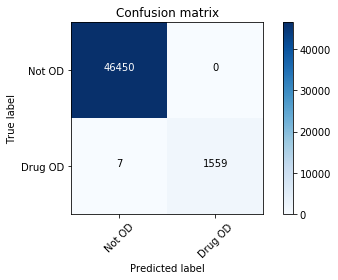

In [29]:
clf=RandomForestClassifier(n_estimators=500, max_depth=100, max_features='auto', random_state=1234)
clf.fit(X_train_final, y_train)

predicted=clf.predict(X_train_final)
print(classification_report(y_train, predicted))

cnf_matrix=metrics.confusion_matrix(y_train, predicted)
class_names = ['Not OD', 'Drug OD']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

### Deploy on test data

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     35214
          1       0.95      0.98      0.97       912

avg / total       1.00      1.00      1.00     36126

Confusion matrix, without normalization
[[35170    44]
 [   18   894]]


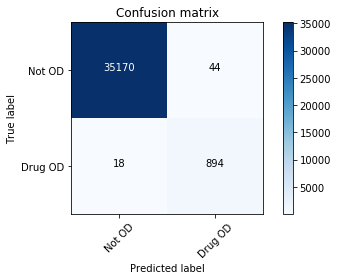

In [30]:
predicted_test=clf.predict(X_test_final)
print(classification_report(y_test, predicted_test))

cnf_matrix=metrics.confusion_matrix(y_test, predicted_test)
class_names = ['Not OD', 'Drug OD']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

### MLP

In [31]:
parameter_space={
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'alpha': [.0001, .01],
}

clf=GridSearchCV(MLPClassifier(), parameter_space, cv=cross_validation, scoring='f1')
clf.fit(X_train_final, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_)

0.970 (+/-0.015) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50)}
0.970 (+/-0.014) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50)}
0.970 (+/-0.013) for {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
0.969 (+/-0.018) for {'alpha': 0.01, 'hidden_layer_sizes': (50, 50, 50)}
0.972 (+/-0.019) for {'alpha': 0.01, 'hidden_layer_sizes': (50, 100, 50)}
0.973 (+/-0.016) for {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Best parameters found:
 {'alpha': 0.01, 'hidden_layer_sizes': (100,)}


### Next tuning step

In [32]:
parameter_space={
    'hidden_layer_sizes': [(100,)],
    'alpha': [.01, .1, .001],
}

clf=GridSearchCV(MLPClassifier(), parameter_space, cv=cross_validation, scoring='f1')
clf.fit(X_train_final, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_)

0.972 (+/-0.023) for {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
0.969 (+/-0.022) for {'alpha': 0.1, 'hidden_layer_sizes': (100,)}
0.970 (+/-0.022) for {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Best parameters found:
 {'alpha': 0.01, 'hidden_layer_sizes': (100,)}


### Re-train with best parameters

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     46450
          1       0.99      0.99      0.99      1566

avg / total       1.00      1.00      1.00     48016

Confusion matrix, without normalization
[[46439    11]
 [    9  1557]]


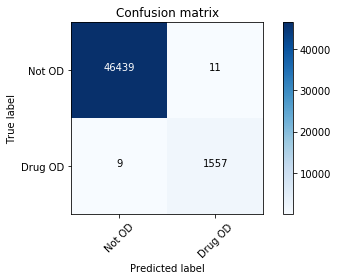

In [33]:
clf=MLPClassifier(hidden_layer_sizes=(100,), alpha=0.01)
clf.fit(X_train_final, y_train)

predicted=clf.predict(X_train_final)
print(classification_report(y_train, predicted))

cnf_matrix=metrics.confusion_matrix(y_train, predicted)
class_names = ['Not OD', 'Drug OD']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

### Deploy on test data

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     35214
          1       0.96      0.97      0.97       912

avg / total       1.00      1.00      1.00     36126

Confusion matrix, without normalization
[[35179    35]
 [   24   888]]


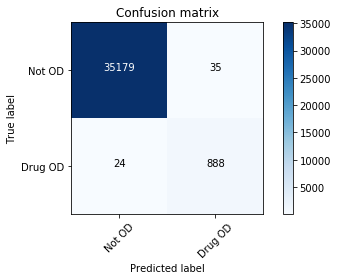

In [34]:
predicted_test=clf.predict(X_test_final)
print(classification_report(y_test, predicted_test))

cnf_matrix=metrics.confusion_matrix(y_test, predicted_test)
class_names = ['Not OD', 'Drug OD']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')